In [1]:
from math import sqrt
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from collections import defaultdict
from skimage import io as io
from skimage import exposure
from skimage.color import rgb2gray
from skimage.feature import daisy
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.feature import hog
from skimage.feature import corner_harris, corner_subpix, corner_peaks
import cv2


In [2]:
with open("data/annotations_trainval2014/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)
with open("data/annotations_trainval2014/annotations/instances_val2014.json") as read_file:
    val = json.load(read_file)

Number of images in 2014 train: 82783
Number of images in 2014 val: 40504

Number of annotations in 2014 train: 604907
Number of annotations in 2014 val: 291875

Number of annotations/image in 2014 train: 7.307140354903785
Number of annotations/image in 2014 val: 7.206078412008691

82081
82081
Label density in 2014 train: 0.0913392544362973
Label density in 2014 val: 0.09007598015010863
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])




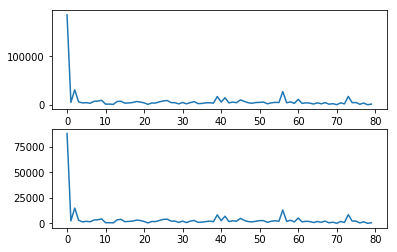


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]


[('hair drier', 74), ('toaster', 78), ('scissors', 444), ('bear', 462), ('parking meter', 512), ('microwave', 539), ('toothbrush', 634), ('fire hydrant', 650), ('stop sign', 686)]

10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]


[('handbag', 4116), ('traffic light', 4362), ('bowl', 4920), ('dining table', 5244), ('cup', 7036), ('bottle', 8384), ('book', 8561), ('chair', 13135), ('car', 15014), ('person', 88153)]


In [3]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
val_images = val["images"]
print("Number of images in 2014 train: "+str(len(train_images)))
print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
train_annotations = train["annotations"]
#print(train_annotations[1:20])
val_annotations = val["annotations"]
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")
train_categories = np.zeros(100, dtype=object)
val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
print(len(itemsets))
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
for annotation in val_annotations:
    val_categories[annotation['category_id']] += 1
train_categories = train_categories[train_categories != 0]
val_categories = val_categories[val_categories != 0]
print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    #print(categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
for i in range(0, len(val_categories)):
    #print(categories[i]["name"] + ": " + str(train_categories[i]))
    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
plt.subplot(212)
plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
print(val_categories[-10:])

In [4]:
image_id = 9 #9,25,30,34,36,49
items = []
for annotation in train_annotations: 
    if annotation['image_id'] == image_id:
        #print(annotation)
        items.append(annotation)
print(items)

[{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 407.72, 240.56, 425.79, 230.4, 441.6, 229.27, 447.25, 237.18, 447.25, 256.38, 456.28, 254.12, 475.48, 263.15, 486.78, 271.06, 49

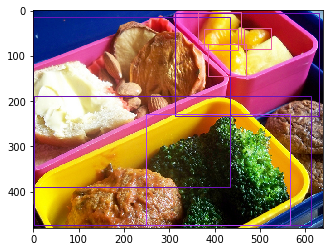

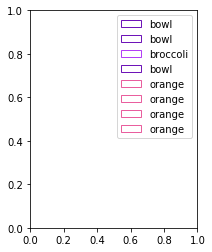

In [5]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(image)
colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

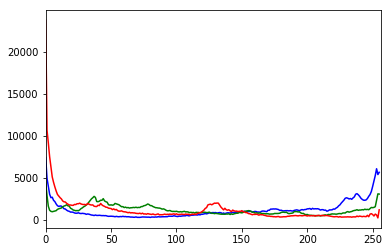

In [6]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


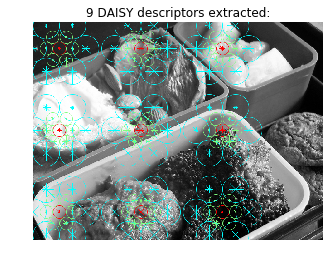

In [7]:
descs, descs_img = daisy(gray_img, step=180, radius=58, rings=2, histograms=6,
                         orientations=8, visualize=True)

#print(descs)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()


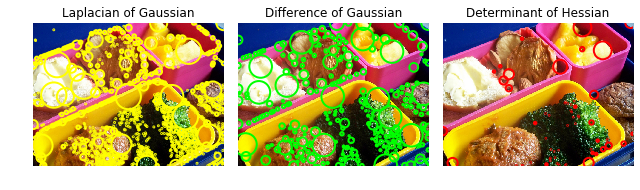

In [8]:
blobs_log = blob_log(gray_img, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(gray_img, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


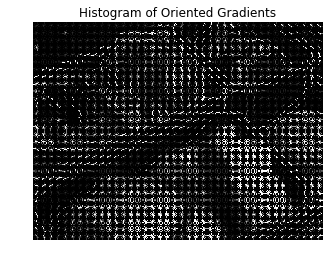

In [9]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()

[[0.09981765 0.09617882 0.09225725 ... 0.64710627 0.64710627 0.63562431]
 [0.10597137 0.09869373 0.09393882 ... 0.65887098 0.65102784 0.63534157]
 [0.09085059 0.08692902 0.08468902 ... 0.66279255 0.65494941 0.63926314]
 ...
 [0.00643647 0.00921922 0.01005255 ... 0.04132196 0.04156706 0.02860314]
 [0.00586314 0.00529765 0.01538078 ... 0.04402157 0.01767961 0.01376588]
 [0.00474706 0.00529765 0.01481529 ... 0.01660118 0.01658627 0.02134902]]


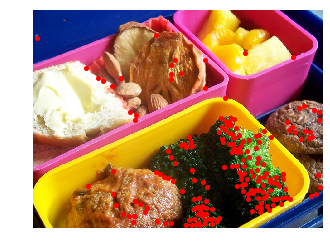

In [10]:
print(gray_img)
coords = corner_peaks(corner_harris(gray_img), min_distance=5)

fig, (ax) = plt.subplots(1, figsize=(8, 4))

ax.axis('off')
ax.imshow(image)
ax.plot(coords[:, 1], coords[:, 0], 'or', ms=4)